## Let's do a thing

In [1]:
from PIL import Image
from shapely.geometry import Polygon, Point, shape
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import geopandas as gpd

## Adorable golden retriever incoming...

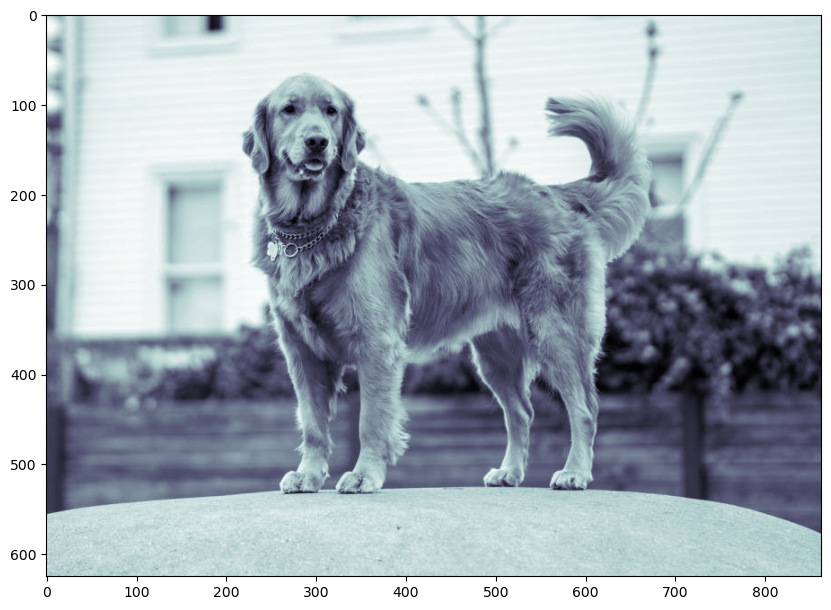

In [2]:
image = Image.open('retriever.jpeg').convert('L')

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(image, cmap='bone')  # because its a dog

## Generate some completely random data as if we're doing object detection on this golden retriever...

<AxesSubplot:>

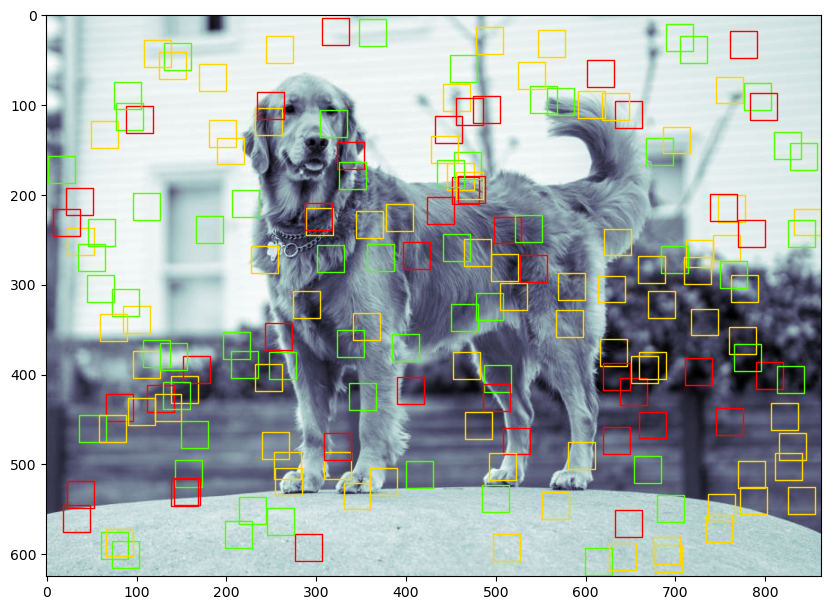

In [3]:
# Create a large polygon from the given bounds
large_polygon = Polygon.from_bounds(0, 0, image.width, image.height)

# Define the width and height of the smaller polygons
small_width = 30
small_height = 30

# Define the number of smaller polygons to create
num_polygons = 180

# Create a list to store the smaller polygons
small_polygons = []

# Loop through each smaller polygon to create it at a random location within the large polygon
for i in range(num_polygons):
    # Generate a random point within the bounds of the large polygon
    x = random.uniform(large_polygon.bounds[0], large_polygon.bounds[2] - small_width)
    y = random.uniform(large_polygon.bounds[1], large_polygon.bounds[3] - small_height)
    point = Point(x, y)
    
    # Check if the point is within the large polygon
    if large_polygon.contains(point):
        # If so, create a smaller polygon at the point
        small_polygon = Polygon([(x, y), (x + small_width, y), (x + small_width, y + small_height), (x, y + small_height)])
        
        # Add the smaller polygon to the list
        small_polygons.append(small_polygon)

image_bounds = gpd.GeoDataFrame(geometry=[large_polygon])
boxes = gpd.GeoDataFrame(geometry=small_polygons)

options = ['A', 'B', 'C']
lbls = [random.choice(options) for _ in range(num_polygons)]
boxes['label'] = lbls

fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.imshow(image, cmap='bone')  # because its a dog
boxes.plot(ax=ax, column='label', cmap='prism', facecolors='None', linewidth=1)

In [4]:
boxes.head()

,geometry,label
0,"POLYGON ((615.547 360.425, 645.547 360.425, 64...",B
1,"POLYGON ((632.407 95.188, 662.407 95.188, 662....",A
2,"POLYGON ((288.352 214.358, 318.352 214.358, 31...",B
3,"POLYGON ((810.046 129.668, 840.046 129.668, 84...",C
4,"POLYGON ((309.016 486.619, 339.016 486.619, 33...",B


## Make some functions to do stuff... there must be better funcitons somewhere but these are fine

In [5]:
def generate_image_tiles(image_name, image, step: int = 256, overlap: int = 20):

    width = image.width
    height = image.height

    # Calculate the number of steps needed to cover the entire width and height
    num_x_steps = int(np.ceil(width / (step - overlap)))
    num_y_steps = int(np.ceil(height / (step - overlap)))

    # Create an array of start points for each x and y step
    x_starts = np.arange(num_x_steps) * (step - overlap)
    y_starts = np.arange(num_y_steps) * (step - overlap)

    # Create an array of end points for each x and y step
    x_ends = np.minimum(x_starts + step, width)
    y_ends = np.minimum(y_starts + step, height)

    # Filter out the ranges that are not exactly 256 units long
    x_ranges = np.vstack((x_starts, x_ends)).T
    x_ranges = x_ranges[x_ranges[:, 1] - x_ranges[:, 0] == step]

    y_ranges = np.vstack((y_starts, y_ends)).T
    y_ranges = y_ranges[y_ranges[:, 1] - y_ranges[:, 0] == step]

    # Create a meshgrid of the x and y ranges
    x_mesh, y_mesh = np.meshgrid(x_ranges[:, 0], y_ranges[:, 0])

    # Combine the x and y meshgrids into a single array of ranges
    ranges = np.vstack((x_mesh.flatten(), y_mesh.flatten(), x_mesh.flatten() + step, y_mesh.flatten() + step)).T

    image_tiles = []
    image_tile_polygons = []
    image_tile_names = []
    
    for x1, y1, x2, y2 in ranges:
        tile = image.crop([x1, y1, x2, y2])
        tile_polygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
        tile_name = f'{image_name}_{x1}_{y1}_{x2}_{y2}'

        image_tiles.append(tile)
        image_tile_polygons.append(tile_polygon)
        image_tile_names.append(tile_name)
        tile.save(tile_name + '.png')

    return gpd.GeoDataFrame(index=image_tile_names, geometry=image_tile_polygons), image_tiles

def generate_label_tiles(tiles: gpd.GeoDataFrame, labels: gpd.GeoDataFrame, pct_area_within: int = 50):

    translated_labels = []
    for tile in tiles.iterfeatures():

        tile_id = tile['id']
        tile_geom = shape(tile['geometry'])
        chip = gpd.GeoDataFrame(geometry=[tile_geom])

        # Find all labels with more than 20%
        intersection = gpd.overlay(boxes, chip, how='intersection')
        intersection['percent_area'] = intersection.area / boxes.area * 100
        intersection = intersection.loc[intersection['percent_area']>pct_area_within].reset_index(drop=True)

        # Calculate the x and y offsets needed to shift the first polygon to (0,0)
        x_offset = -tile_geom.bounds[0]
        y_offset = -tile_geom.bounds[1]

        # Shift all polygons in the geoseries by the same amount
        chip_shift = chip.translate(x_offset, y_offset)
        intersection_shift = intersection.translate(x_offset, y_offset)
        intersection_new = intersection.set_geometry(intersection.translate(x_offset, y_offset))

        # If there was no intersection we still want a label
        if intersection_new.empty:
            intersection_new['geometry'] = [None]

        # Fill out a dataframe with the label information
        intersection_df = pd.DataFrame()
        intersection_df['geometry'] = intersection_new['geometry']
        intersection_df['image_id'] = tile_id
        intersection_df['label'] = intersection_new['label']

        translated_labels.append(intersection_df)

    df = pd.concat(translated_labels)
    return gpd.GeoDataFrame(df, geometry='geometry')

## Pick our tile size and overlap

In [6]:
step = 256
overlap = 50

tiles, images = generate_image_tiles(image_name='retriever', image=image, step=step, overlap=overlap)
labels = generate_label_tiles(tiles=tiles, labels=boxes)

In [7]:
tiles.head(10)

,geometry
retriever_0_0_256_256,"POLYGON ((0.000 0.000, 256.000 0.000, 256.000 ..."
retriever_206_0_462_256,"POLYGON ((206.000 0.000, 462.000 0.000, 462.00..."
retriever_412_0_668_256,"POLYGON ((412.000 0.000, 668.000 0.000, 668.00..."
retriever_0_206_256_462,"POLYGON ((0.000 206.000, 256.000 206.000, 256...."
retriever_206_206_462_462,"POLYGON ((206.000 206.000, 462.000 206.000, 46..."
retriever_412_206_668_462,"POLYGON ((412.000 206.000, 668.000 206.000, 66..."


In [8]:
labels

,geometry,image_id,label
0,"POLYGON ((52.309 237.190, 22.309 237.190, 22.3...",retriever_0_0_256_256,B
1,"POLYGON ((48.927 147.807, 78.927 147.807, 78.9...",retriever_0_0_256_256,B
2,"POLYGON ((75.920 227.085, 45.920 227.085, 45.9...",retriever_0_0_256_256,C
3,"POLYGON ((125.482 70.310, 155.482 70.310, 155....",retriever_0_0_256_256,B
4,"POLYGON ((21.771 221.978, 51.771 221.978, 51.7...",retriever_0_0_256_256,A
...,...,...,...
17,"POLYGON ((37.828 145.199, 67.828 145.199, 67.8...",retriever_412_206_668_462,C
18,"POLYGON ((115.100 90.665, 145.100 90.665, 145....",retriever_412_206_668_462,A
19,"POLYGON ((109.045 46.222, 139.045 46.222, 139....",retriever_412_206_668_462,C
20,"POLYGON ((83.477 236.095, 53.477 236.095, 53.4...",retriever_412_206_668_462,B


## Plot the result so we know we didn't mess up...

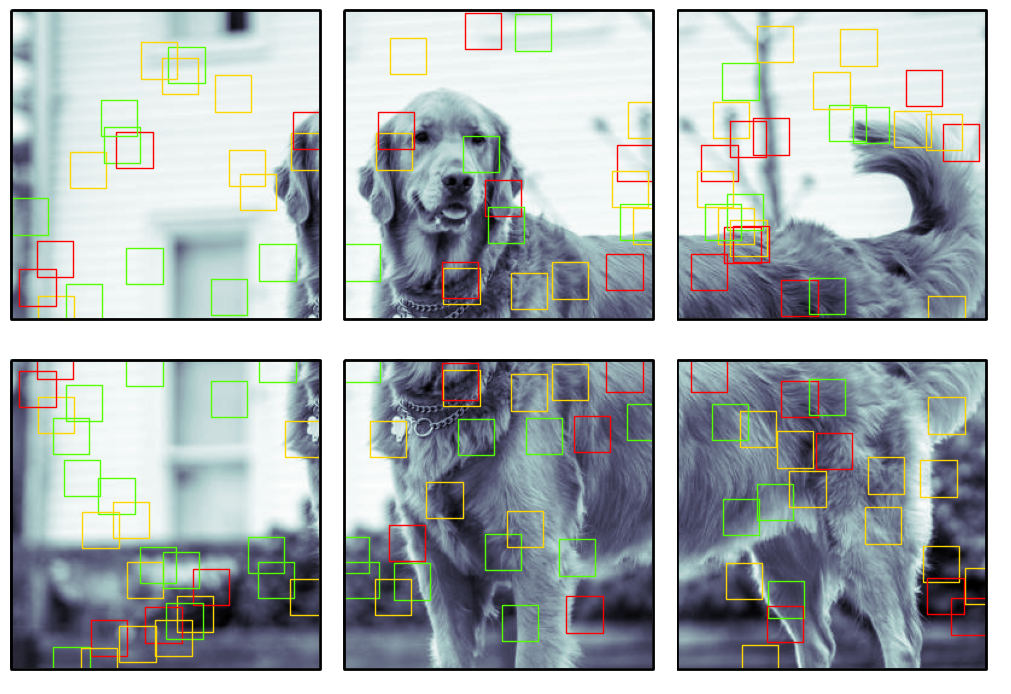

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7), layout='constrained')
for ax, img_id, img in zip(axs.flat, list(labels.image_id.unique()), images):
    ax.imshow(img, cmap='bone')  # because its a dog...
    gpd.GeoSeries(Polygon.from_bounds(0,0,step,step)).boundary.plot(ax=ax, color='black', linewidth=2)
    labels[labels['image_id']==img_id].plot(ax=ax, column='label', cmap='prism', facecolors='None', linewidth=1)
    ax.axis('off')